# Computational Exercise 12: Beyond Supervised Learning

---

**This exercise is optional.** Please note that no code modifications are required in this exercise. Please read through the written portions and outputs, then consider the four written questions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Loading the `digits` dataset

In this exercise, we'll use a dataset of handwritten digits to illustrate differences between supervised learning, unsupervised learning, semi-supervised learning, and active learning. The dataset is lower resolution than MNIST, which will make it easier to work with for this exercise.

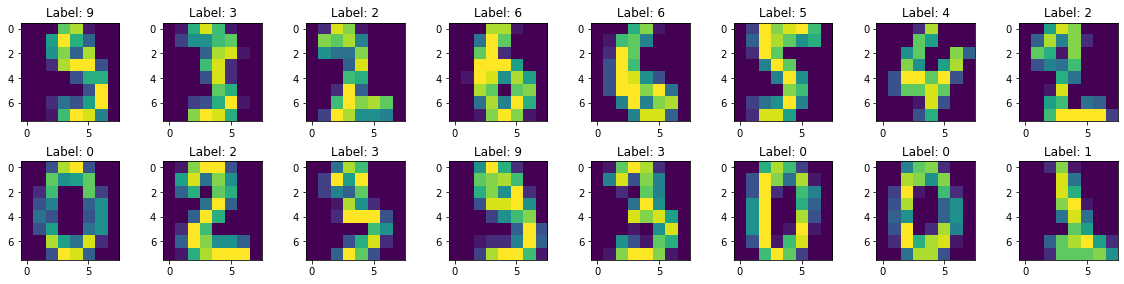

In [2]:
from sklearn import datasets
digits = datasets.load_digits()
fig, axs = plt.subplots(ncols=8, nrows=2, figsize=(16, 4))
for ax in axs:
    for a in ax:
        idx = np.random.randint(0, high=len(digits['images']))
        a.imshow(digits['images'][idx])
        a.set_title('Label: %i' % digits['target'][idx])
plt.tight_layout()

## Supervised Learning

In supervised learning, our goal is to learn a function that maps inputs to a desired output based on a training set of many known input-output pairs. In digit classification, our inputs are images of handwritten digits, and our desired outputs are the digits they represent. Almost everything we've discussed so far in the course, from logistic regression to CNNs to text classification, has been supervised learning. Although we have focused on classification, supervised learning also includes regression (e.g. linear regression). The code below demonstrates supervised learning with the `digits` dataset.

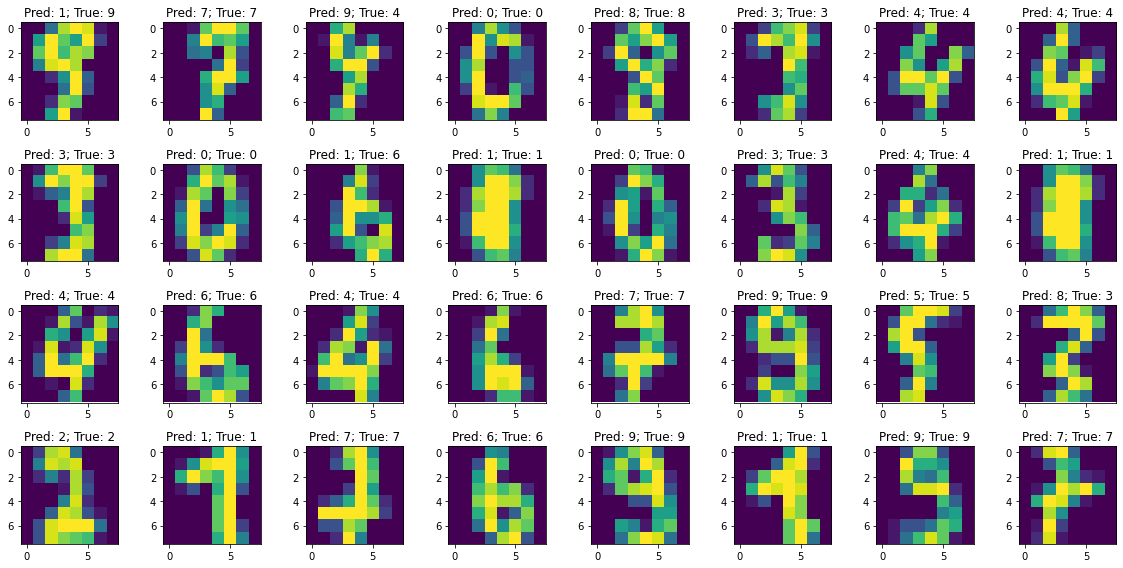

In [3]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(256, ))
mlp.fit(digits['data'][:1500], digits['target'][:1500])
predicted = mlp.predict(digits['data'])
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(16, 8))
for ax in axs:
    for a in ax:
        idx = np.random.randint(1500, high=len(digits['images']))
        a.imshow(digits['images'][idx])
        a.set_title('Pred: %i; True: %i' % (predicted[idx], digits['target'][idx]))
plt.tight_layout()

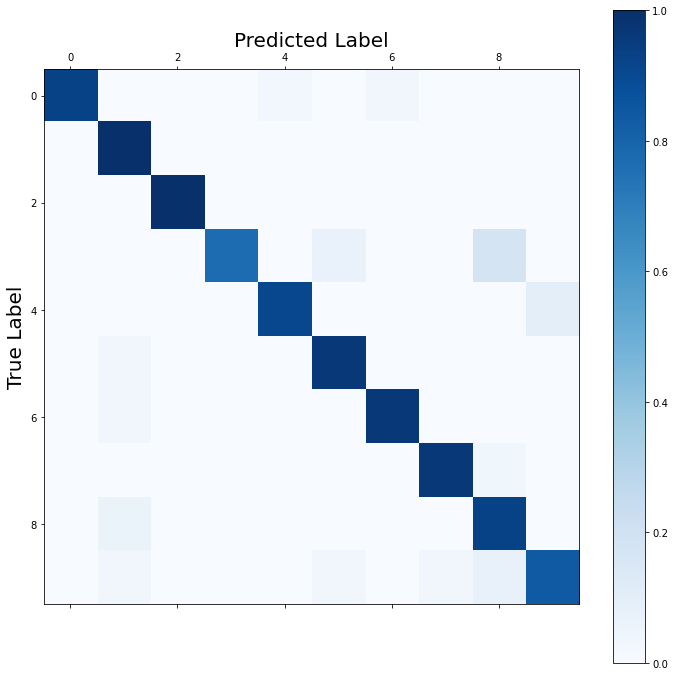

Accuracy = 92.59


In [4]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(predicted_labels, true_labels, normalize=True, title='Predicted Label', ylab='True Label'):
    cm = confusion_matrix(true_labels, predicted_labels)
    if normalize == True:
        cm = cm / np.sum(cm, axis=1)
    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.matshow(cm, cmap='Blues')
    fig.colorbar(im, ax=ax)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylab, fontsize=20)
    plt.show()
plot_confusion_matrix(predicted[1500:], digits['target'][1500:])
print("Accuracy = %.2f" % (100 * sum(digits['target'][1500:] == predicted[1500:]) / len(predicted[1500:])))

### Exercise 12.1: Supervised Learning Application

Describe a medical application of supervised learning that was not discussed in class or in our readings. Be sure to identify both the inputs and the desired outputs.

--- 

**YOUR RESPONSE HERE**

# Unsupervised Learning

In unsupervised learning, our goal is to **discover structure in unlabeled data**. In other words, we still have many inputs, but there aren't any corresponding outputs that we'd like to replicate. Unsupervised learning includes:

- clustering, in which we divide our dataset into distinct groups with similar characteristics
- dimensionality reduction techniques such as PCA, factor analysis, and autoencoders

In the code below, we use the k-means clustering algorithm to divide our digits into 10 visually distinct groups. Since our algorithm doesn't know which digits these images represent, the index for a given group won't match the digits contained in it. In the block below, we'll take a look at the images assigned to group 0. Do most of these images represent the same digit?

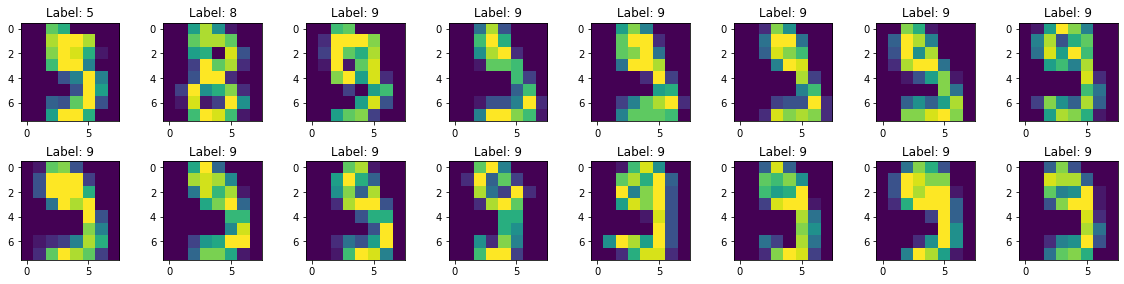

In [5]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10)
predicted = km.fit_predict(digits['data'])
fig, axs = plt.subplots(ncols=8, nrows=2, figsize=(16, 4))
for idx in range(16):
    digits['images'][predicted == 0][idx]
    axs[idx // 8, idx % 8].imshow(digits['images'][predicted == 0][idx])
    axs[idx // 8, idx % 8].set_title('Label: %i' % digits['target'][predicted == 0][idx])
plt.tight_layout()

Let's plot a matrix showing how many images of each digit were assigned to the different groups. For the most part, do the groups represent distinct digits?

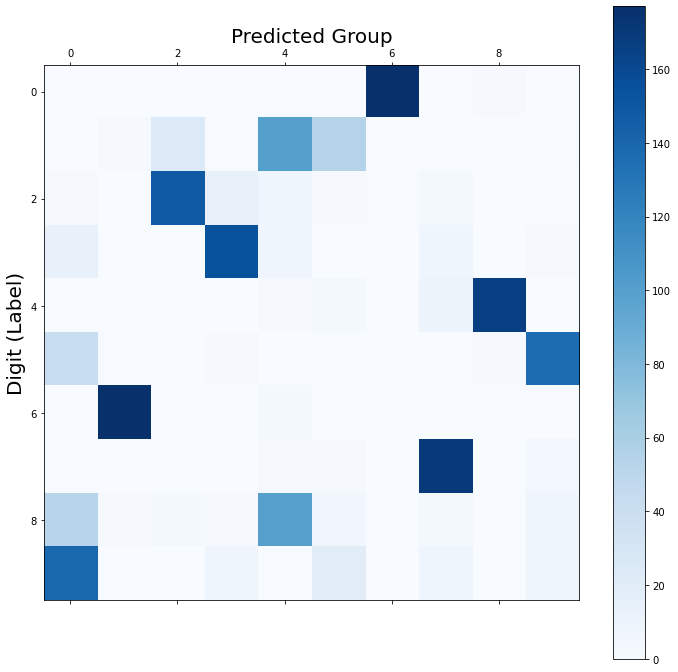

In [6]:
plot_confusion_matrix(predicted, digits['target'], normalize=False, title='Predicted Group', ylab='Digit (Label)')

### Exercise 12.2: Unsupervised Learning Application

Describe a medical application of unsupervised learning that was not discussed in class or in our readings. Be sure to describe the goal and explain why supervised learning can't or shouldn't be used instead.

--- 

**YOUR RESPONSE HERE**

# Semi-Supervised Learning

In semi-supervised learning, our goal is the same as in supervised learning: we'd to learn a function that maps inputs to a desired output based on known input-output pairs. Unlike in supervised learning, however, **the output (i.e. label) is known only for *some* of our training examples, and unknown for others**. In this situation, we could use supervised learning by training only on the examples with known labels. However, in semi-supervised learning we also use the unlabeled examples to help us understand the structure of the data, leading to better performance. Intuitively, semi-supervised learning works by identifying distinct clusters of examples such that all examples with the same label belong to a single cluster.

We begin by specifying that 40 of our 1577 handwritten digits will be labeled. We'll set all other labels to -1, which tells our algorithm that the label is unknown.

In [7]:
n_labeled_points = 40
n_total_samples = len(digits['target'])
unlabeled_indices = np.random.choice(n_total_samples, n_total_samples - n_labeled_points, replace=False)
labeled_indices = np.arange(n_total_samples)[~unlabeled_indices]
y_train = np.copy(digits['target'])
y_train[unlabeled_indices] = -1

print('We have', n_total_samples, 'handwritten digits,', len(unlabeled_indices), 'of which are not labeled')

We have 1797 handwritten digits, 1757 of which are not labeled


Let's plot a row of handwritten digits that *are* labeled, and a second row of handwritten digits that are not.

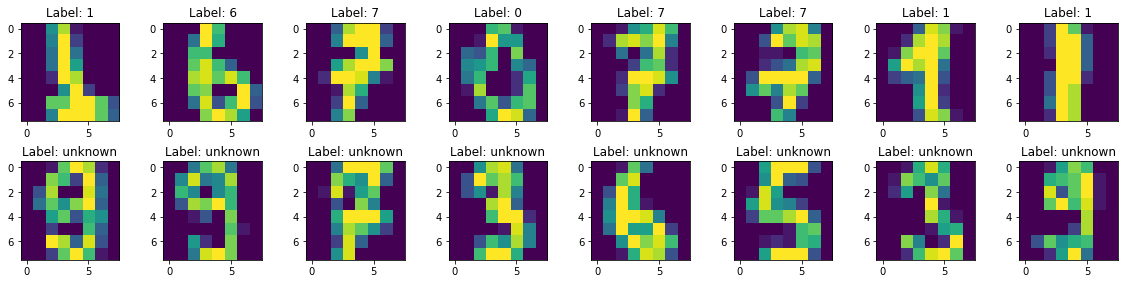

In [8]:
fig, axs = plt.subplots(ncols=8, nrows=2, figsize=(16, 4))
for i, ax in enumerate(axs[0]):
    idx = np.random.choice(labeled_indices)
    ax.imshow(digits['images'][idx])
    ax.set_title('Label: %i' % digits['target'][idx])
for i, ax in enumerate(axs[1]):
    idx = np.random.choice(unlabeled_indices)
    ax.imshow(digits['images'][idx])
    ax.set_title('Label: unknown')
plt.tight_layout()

We can now use a semi-supervised learning algorithm called `label_propagation` to infer the unknown labels based on the known labels. Then, we'll plot the confusion matrix and calculate the accuracy of our predictions for the unknown labels.

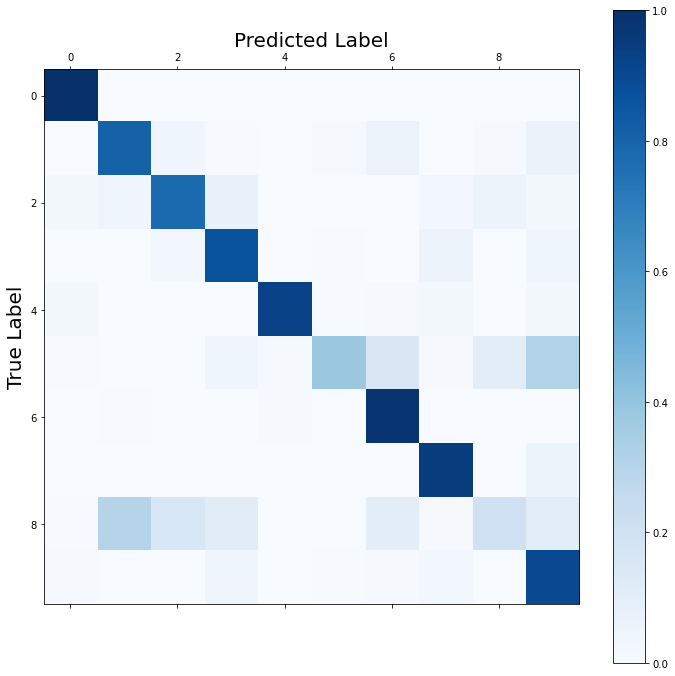

Accuracy = 77.92


In [9]:
from sklearn.semi_supervised import LabelPropagation
lp_model = LabelPropagation(gamma=0.25, max_iter=20)
lp_model.fit(digits['data'], y_train)
predicted_labels = lp_model.transduction_[unlabeled_indices]
true_labels = digits['target'][unlabeled_indices]
plot_confusion_matrix(predicted_labels, true_labels)
print("Accuracy = %.2f" % (100 * sum(true_labels == predicted_labels) / len(true_labels)))

### Exercise 12.3: Semi-Supervised Learning Application

Describe a medical application of semi-supervised learning that was not discussed in class or in our readings. Be sure to describe the goal and explain why we might expect labels to be available for some inputs but not others.

---

**YOUR RESPONSE HERE**

# Active Learning

In active learning, we begin the same way we did in semi-supervised learning: our output (i.e. label) is known only for *some* of our training examples, and unknown for others. This time, however, **we'll have an opportunity to *request* the labels for additional examples of our choosing**. In active learning, we assume **we must be judicious in making these requests** because (a) we can only make a limited number of them, or (b) each request is associated with a cost. For example, we might be requesting the labels from a clinician who's on service and can't afford to spend all day labeling our data. 

Our goal, then, is to carefully select which labels we need most. We should pick labels for which we're most uncertain, or that we expect will improve our ability to identify the best model parameters.

In the example below, we begin by training the same semi-supervised learning algorithm as before -- `label_propagation` -- with only 10 labeled points, resulting in low accuracy. We then identify the 10 examples whose labels we're most uncertain about, as measured by the entropy of our predictive distribution over the labels. After obtaining the labels for these 10 points, we retrain our model. We repeat this process 5 times while printing the confusion matrix and accuracy in each iteration. Finally, we plot the images whose labels we requested.

Since we have access to all the labels in this example, "obtaining new labels" is simply a matter of making them available to the `label_propagation` algorithm. In a real-world problem, however, active learning would involve acquiring new labels from an outside source (e.g. an expert).

An import question is whether active learning is more effective than simply requesting labels at random. Is the accuracy of active learning after iteration 3 (when we have 40 labeled examples) better than the accuracy we obtained using semi-supervised learning with 40 randomly-selected labels?


Iteration 0 ______________________________________________________________________
Label Spreading model: 10 labeled & 1787 unlabeled (1797 total)
Confusion matrix
[[115   0  11   0   6  23  10  16]
 [  1 141   8   0   0   2  23   1]
 [  3   2 151   0   4   1   7  14]
 [ 21   0   0 110   1  36  10   2]
 [  1   0  19   3  93   1   4  60]
 [  2   0   0  21   0 154   0   3]
 [ 22   4   0   0   1   0 149   0]
 [  0   0  47   0   2   3  14 113]]
Accuracy = 57.41

Iteration 1 ______________________________________________________________________
Label Spreading model: 20 labeled & 1777 unlabeled (1797 total)
Confusion matrix
[[167   0   0   0   1   0   4   0   0   5]
 [  0 106  23   1   0   6   9   7   2  27]
 [  0   1 158   1   0   0   2  12   0   0]
 [  0   1   2 130   0   4   0   6   4  35]
 [  3  20   0   0 116   0  33   4   3   0]
 [  0   0   0   0   2 165   3   0   0   9]
 [  0   2   0   0   0   1 175   0   0   1]
 [  0  15   1   0   5   2   0 135  18   0]
 [  0  33   6   2   0   5  1

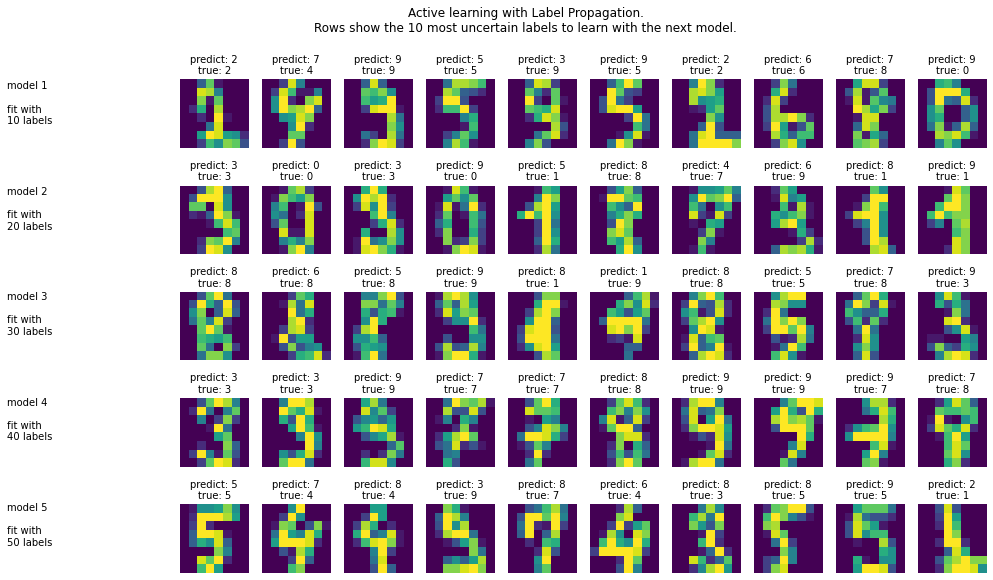

In [10]:
from scipy import stats

n_labeled_points = 10
n_total_samples = len(digits['target'])
n_iterations = 5

unlabeled_indices = np.random.choice(n_total_samples, n_total_samples - n_labeled_points, replace=False)

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)

for i in range(n_iterations):

    y_train = np.copy(digits['target'])
    y_train[unlabeled_indices] = -1

    lp_model = LabelPropagation(gamma=0.25, max_iter=20)
    lp_model.fit(digits['data'], y_train)

    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = digits['target'][unlabeled_indices]

    cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

    print("\nIteration %i %s" % (i, 70 * "_"))
    print("Label Spreading model: %d labeled & %d unlabeled (%d total)"
          % (n_labeled_points, n_total_samples - n_labeled_points,
             n_total_samples))
    print("Confusion matrix")
    print(cm)
    print("Accuracy = %.2f" % (100 * sum(true_labels == predicted_labels) / len(true_labels)))

    # compute the entropies of transduced label distributions
    pred_entropies = stats.distributions.entropy(
        lp_model.label_distributions_.T)

    # select up to 5 digit examples that the classifier is most uncertain about
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.in1d(uncertainty_index, unlabeled_indices)][:10]

    # keep track of indices that we get labels for
    delete_indices = np.array([], dtype=int)

    # for more than 5 iterations, visualize the gain only on the first 5
    if i < 5:
        fig.text(.05, (1 - (i + 1) * .183),
               "model %d\n\nfit with\n%d labels" %
               ((i + 1), i * 10 + 10), size=10)
    for index, image_index in enumerate(uncertainty_index):
        image = digits['images'][image_index]

        # for more than 5 iterations, visualize the gain only on the first 5
        if i < 5:
            sub = fig.add_subplot(5, 10, index + 1 + (10 * i))
            sub.imshow(image)
            sub.set_title("predict: %i\ntrue: %i" % (
                lp_model.transduction_[image_index], digits['target'][image_index]), size=10)
            sub.axis('off')

        # labeling 5 points, remote from labeled set
        delete_index, = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

fig.suptitle("Active learning with Label Propagation.\nRows show the 10 most "
           "uncertain labels to learn with the next model.", y=1.02)
plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
plt.show()

### Exercise 12.4: Active Learning Application

Describe a medical application of active learning that was not discussed in class or in our readings. Be sure to describe why the active learning paradigm is a good fit for this application. For example, you might describe why it's expensive or difficult to acquire labels.

--- 

**YOUR RESPONSE HERE**